# Entendimento do Problema e Planejamento da Solução

    O que preciso entregar? 
            Web App com modelo em produção fazendo previsões de inadimplência.
    
    O que precisa ser feito? 
             Construção do Modelo;
             Deployment do Modelo;
         
    Quais ferramentas utilizar? 
           - Python
               1. Biblioteca de manipulação de dados(Pandas,Numpy e Scipy)
               2. Biblioteca de Machine Learning (Scikit-Learn)
               3. Biblioteca de Balanceamento de Dados (Imbalanced Learn)
               4. Biblioteca de Vizualização de Dados (Matplotlib e Seaborn)
            - Render (Cloud para Deployment)
            - Streamlit (Web APP)
    
    Como fazer? 
                - Limpeza dos Dados.
                - Descrição dos Dados.
                - Engenharia de Atributos.
                - Filtragem de Variáveis.
                - Análise Exploratória de Dados.
                - Preparação dos Dados.
                - Seleção de Atributos.
                - Ajuste Fino do Modelo.
                - Calibrar Métricas de EAD e LGD apartir do modelo criado.
                - Construção do WebAPP usando streamlit.
                - Deployment do modelo usando Render(Nuvem que usaremos)

## Metadados

Essas são as colunas iniciais do dataset, porém, transformei desde o início o nome desses atributos para melhorar as análises.


    X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
    X2: Gender (1 = male; 2 = female).
    X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
    X4: Marital status (1 = married; 2 = single; 3 = others).
    X5: Age (year).
    X6–X11: History of past payment. We tracked the past monthly payment records (from April to September,2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .; X11 = the repayment status in April, 2005. The measurement scale for the repayment status is:
    -1 = pay duly; 
    1 = payment delay for one month;
    2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
    X12–X17: Amount of bill statement (NT dollar).
    X12 = amount of bill statement in September, 2005;
    X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
    X18–X23: Amount of previous payment (NT dollar).
    X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .; X23 = amount paid in April, 2005.
    
    
     default: 1: Inadimplente 0: Não inadimplente
 _________________________________________________________________________________________________________________    
     
     
     LIMIT_BAL : Valor do crédito concedido (NT dólar).
     SEX       : Sexo (1 = masculino; 2 = feminino).
     EDUCATION : Educação (1 = pós-graduação; 2 = universidade; 3 = ensino médio; 4 = outros).
     MARRIAGE  : Estado civil (1 = casado; 2 = solteiro; 3 = outros).
     AGE       : Idade (ano).
     PAY_0 – PAY_5: Histórico de pagamentos anteriores. Rastreamos os últimos registros de pagamento mensal (de abril a setembro de 2005) da seguinte forma: X6 = o status do pagamento em setembro de 2005; X7 = situação de amortização em agosto de 2005; . . .; X11 = o status de reembolso em abril de 2005. A escala de medição para o status de reembolso é:
    -1 = pagar em dia;
     1 = atraso de pagamento por um mês;
     2 = atraso de pagamento de dois meses; . . .; 8 = atraso de pagamento de oito meses; 9 = atraso de pagamento de nove meses ou mais.
     BILL_AMT1 – BILL_AMT6: Valor do extrato da conta (NT dólar).
     BILL_AMT1 = valor do extrato da conta em setembro de 2005;
     BILL_AMT2 = valor do extrato da conta em agosto de 2005; . . .; X17 = valor do extrato da fatura em abril de 2005.
     BILL_PAY1–BILL_PAY6: Valor do pagamento anterior (NT dólar).
     BILL_PAY1 = valor pago em setembro de 2005; X19 = valor pago em agosto de 2005; . . .; X23 = valor pago em abril de 2005.

# PASSO 0 - Imports

Nesta seção vamos organizar as principais bibliotecas que serão utilizadas durante este projeto, bem como as funções auxiliares. 

In [1]:
import math
import pandas as pd
import numpy  as np
import inflection
import requests
import random
import pickle
import warnings
import xgboost as xgb
import seaborn as sns


from boruta               import BorutaPy
from scipy                import stats      as ss
from matplotlib           import pyplot     as plt
from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler , LabelEncoder , OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
#função para calcular o cramer_v, utilizada para calcular a correlação entre variáveis categóricas.
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#condigura as funções padrão do jupyter notebook para visualização de dados.
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

## 0.1 Loading Data

In [3]:
#carrega o dataset no dataframe
df_raw = pd.read_csv('data/dataset_trat.csv', sep=';')

In [4]:
df_raw.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,2,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,2,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,2,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,2,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,1,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df_raw.shape

(30000, 26)

In [6]:
df_raw.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default'],
      dtype='object')

In [7]:
df_raw['SEX'].unique()

array([2, 1])

In [8]:
#estou tornando essa variável numérica em categórica com finalidade de melhorar analisa-la posteriormente.
df_raw['SEX'] = df_raw['SEX'].apply(lambda x: 'male' if x==1 else 'female')

In [9]:
df_raw['SEX'].unique()

array(['female', 'male'], dtype=object)

In [10]:
df_raw['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [11]:
df_raw['EDUCATION'] = df_raw['EDUCATION'].apply(lambda x: 'graduate school' if x == 1 else 'university' if x==2 else
                                               'high school' if x==3 else 'others')

In [12]:
df_raw['EDUCATION'].unique()

array(['university', 'graduate school', 'high school', 'others'],
      dtype=object)

In [13]:
df_raw['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [14]:
df_raw['MARRIAGE'] = df_raw['MARRIAGE'].apply(lambda x: 'married' if x==1 else 'single' if x==2 else 'others')

In [15]:
df_raw['MARRIAGE'].unique()

array(['married', 'single', 'others'], dtype=object)

## 0.2 Divisão do Conjunto de Dados

    Nesta seção irei dividir o conjunto de treino e o conjunto de teste, esse conjunto de teste ficará separado para evitar vazamento de dados(data leakage). O conjunto de dados que será usado para contruir o dataset será apenas o conjunto de treino.

In [16]:
df_raw.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [17]:
#Verificando o número de clientes inadimplentes do dataset.
print("O dataset tem {:.2f}% de inadimplentes." .format(df_raw[df_raw['default'] == 1].shape[0]*100/df_raw.shape[0]))

O dataset tem 22.12% de inadimplentes.


In [18]:
# A variável safra foi criada para criar janelas de pedidos de crédito.
# O dataset out of time será o dataset utilizado para testar o modelo ao final.
# Out of Time(OOT)
df_OOT = df_raw[df_raw['SAFRA'] > 200604].copy()

In [19]:
df_OOT.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
21000,21001,200605,30000,male,university,married,36,1,-1,-1,...,1170,780,0,780,0,1170,0,0,0,0
21001,21002,200605,280000,male,high school,married,40,2,0,0,...,191291,189029,192023,10000,9000,8000,6738,6974,7600,1
21002,21003,200605,260000,male,university,married,37,0,0,0,...,23186,14117,15797,3203,6015,5055,2011,4078,4522,0
21003,21004,200605,200000,male,university,single,32,2,0,0,...,0,0,0,7600,4000,0,0,0,0,1
21004,21005,200605,80000,male,university,single,32,2,0,0,...,67352,74448,72928,3000,4005,2500,10000,0,5000,1


In [20]:
df_OOT['SAFRA'].groupby(df_OOT['SAFRA']).count()

SAFRA
200605    3000
200606    3000
200607    3000
Name: SAFRA, dtype: int64

In [21]:
#Esse será o dataset utilizado para treinameto do modelo.
df0_dev = df_raw[df_raw['SAFRA'] <= 200604].copy()
df0_dev.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,female,university,married,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,female,university,single,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,female,university,single,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,female,university,married,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,male,university,married,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


    É necessário que o balanceamento do dataset real seja igual ao balanceamento do dataset separado para treino, pois os dados de treinos precisam retratar a realidades dos dados coletados em ambiente real.

In [22]:
#verificando balanceamento do dataset de treino e do dataset de teste.
print("O dataset de treino tem {:.2f}% de inadimplentes." .format(df0_dev[df0_dev['default'] == 1].shape[0]*100/df0_dev.shape[0]))
print("O dataset de teste tem {:.2f}% de inadimplentes." .format(df_OOT[df_OOT['default'] == 1].shape[0]*100/df_OOT.shape[0]))

O dataset de treino tem 22.84% de inadimplentes.
O dataset de teste tem 20.44% de inadimplentes.


    df0_dev é o dataset que será usado para construir o modelo.
    df_OOT é o dataset que será usado para testar o modelo. OOT(Out of time)

# PASSO 1 - Data Description

    A patir deste ponto usararemos apenas o dataset de treino.
    
    O Objetivo desta seção é fazer uma análise descritiva do nosso dataset de treino, ou seja, verificar os tipos de dados que temos disponíveis, se são variáveis numéricas ou categoricas. Calcular medidas de tendência central e disperção.


In [23]:
df1 = df0_dev.copy()

In [24]:
#verificando o número de linhas e colunas do dataset.
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of Rows: 21000
Number of columns: 26


In [25]:
#verificando tipos de dados
df1.dtypes

ID            int64
SAFRA         int64
LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE     object
AGE           int64
PAY_0         int64
PAY_2         int64
PAY_3         int64
PAY_4         int64
PAY_5         int64
PAY_6         int64
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
default       int64
dtype: object

In [26]:
#Verificando valores faltantes no dataset.
df1.isna().sum()

ID           0
SAFRA        0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [27]:
#separando os atributos categoricos dos atributos numéricos.
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributtes = df1.select_dtypes(exclude=['int64','float64'])

In [28]:
#Calculando algumas medidas descritivas.
#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,1.0,21000.0,20999.0,10500.500000,10500.5,6062.177820,0.000000,-1.200000
1,SAFRA,200510.0,200604.0,94.0,200563.285714,200601.0,45.291798,-0.288063,-1.915213
2,LIMIT_BAL,10000.0,1000000.0,990000.0,163276.365714,130000.0,128677.638299,1.028252,0.602996
3,AGE,21.0,79.0,58.0,35.415286,34.0,9.246949,0.734517,0.045975
4,PAY_0,-2.0,8.0,10.0,0.018476,0.0,1.123405,0.807518,3.099244
5,PAY_2,-2.0,8.0,10.0,-0.103238,0.0,1.203886,0.820207,1.673044
6,PAY_3,-2.0,8.0,10.0,-0.136238,0.0,1.209314,0.917693,2.444372
7,PAY_4,-2.0,8.0,10.0,-0.196381,0.0,1.169821,1.070557,3.897242
8,PAY_5,-2.0,8.0,10.0,-0.234857,0.0,1.144504,1.061523,4.143238
9,PAY_6,-2.0,8.0,10.0,-0.261762,0.0,1.167988,1.002820,3.507251


    Note que temos uma assimetria positiva(Moda < Mediana < Média) para a idade, o que significa que a média da idade está mais a direita da distribuição.

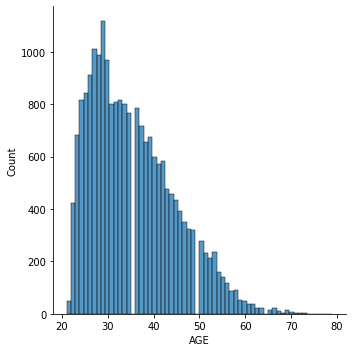

In [29]:
#Verificando como está a distribuição de das idades no dataset.
sns.displot(df1['AGE'],);

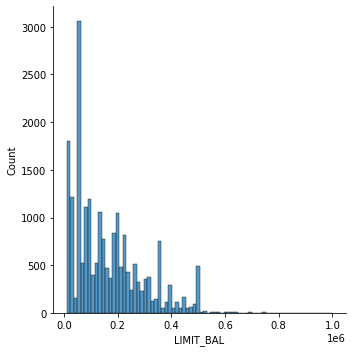

In [30]:
sns.displot(df1['LIMIT_BAL']);

## 1.2 Categorical Attributes

In [31]:
#verificando o número de atributos dentro de cada categoria.
cat_attributtes.apply(lambda x: x.unique().shape[0])

SEX          2
EDUCATION    4
MARRIAGE     3
dtype: int64

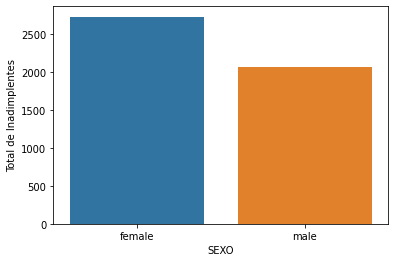

In [32]:
#Verificando o número de inadimplentes por sexo.
aux = df1.loc[df1['default']==1]
aux1 = aux[['SEX','default']].groupby('SEX').sum().reset_index()
sns.barplot(data=aux1 , x='SEX' , y='default');
plt.xlabel('SEXO')
plt.ylabel('Total de Inadimplentes')
plt.show();

Text(0, 0.5, 'Total de Inadimplentes')

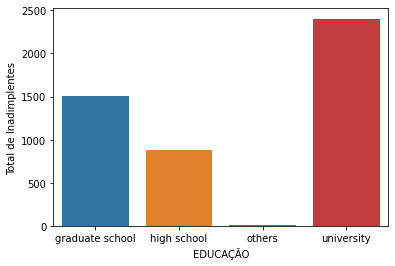

In [33]:
#Verificando o número de inadimplentes por educação.
aux = df1.loc[df1['default']== 1]
aux2 = aux[['EDUCATION','default']].groupby('EDUCATION').sum().reset_index()
sns.barplot(data=aux2 , x='EDUCATION' , y='default');
plt.xlabel('EDUCAÇÃO')
plt.ylabel('Total de Inadimplentes')

Text(0, 0.5, 'Total de Inadimplentes')

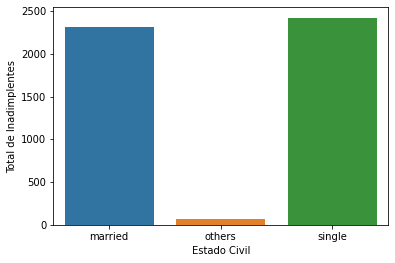

In [34]:
# Verificando o número de inadimplentes por estado civil.
aux = df1.loc[df1['default']== 1]
aux3 = aux[['MARRIAGE','default']].groupby('MARRIAGE').sum().reset_index()
sns.barplot(data=aux3 , x='MARRIAGE' , y='default');
plt.xlabel("Estado Civil")
plt.ylabel('Total de Inadimplentes')

# PASSO 2 - Feature Engeneering

Nesta seção vamos derivar atributos apartir dos atributos já conhecidos. 

In [36]:
df2 = df1.copy()

In [37]:
df2.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default'],
      dtype='object')

    Aqui vamos construir alguns atributos:
        1. SUM_BILL = Soma do valor de todas as faturas. 
        2. AVG_BILL = Média do valor de todas as faturas. 
        3. max_BILL = O valor mais alto de todas as faturas dos últimos meses.
        4. SUM_PAY = Valor total pago das faturas nos últimos meses.
        5. AVG_PAY = Média do valor total pago. 
        6. max_PAY = Valor mais alto pago. 
    

In [38]:
df2['SUM_BILL'] = df2['BILL_AMT1'] + df2['BILL_AMT2'] + df2['BILL_AMT3'] + df2['BILL_AMT4'] + df2['BILL_AMT5'] + df2['BILL_AMT6']   
df2['AVG_BILL'] = df2['SUM_BILL'] / 6
df2['max_BILL'] = df2[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

df2['SUM_PAY'] = df2['PAY_AMT1'] + df2['PAY_AMT2'] + df2['PAY_AMT3'] + df2['PAY_AMT4'] + df2['PAY_AMT5'] + df2['PAY_AMT6']
df2['AVG_PAY'] = df2['SUM_PAY'] / 6
df2['max_PAY'] = df2[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']].max(axis=1)

In [39]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,21000.0,10500.500000,6062.322162,1.000000,5250.750000,10500.500000,15750.250000,2.100000e+04
SAFRA,21000.0,200563.285714,45.292876,200510.000000,200511.000000,200601.000000,200603.000000,2.006040e+05
LIMIT_BAL,21000.0,163276.365714,128680.702162,10000.000000,50000.000000,130000.000000,230000.000000,1.000000e+06
AGE,21000.0,35.415286,9.247169,21.000000,28.000000,34.000000,41.000000,7.900000e+01
PAY_0,21000.0,0.018476,1.123432,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_2,21000.0,-0.103238,1.203915,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_3,21000.0,-0.136238,1.209342,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_4,21000.0,-0.196381,1.169849,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_5,21000.0,-0.234857,1.144531,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_6,21000.0,-0.261762,1.168015,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00


In [40]:
#Construindo as mesmas fetures no dataset de teste
df_OOT['SUM_BILL'] = df_OOT['BILL_AMT1'] + df_OOT['BILL_AMT2'] + df_OOT['BILL_AMT3'] + df_OOT['BILL_AMT4'] + df_OOT['BILL_AMT5'] + df_OOT['BILL_AMT6']   
df_OOT['AVG_BILL'] = df_OOT['SUM_BILL'] / 6
df_OOT['max_BILL'] = df_OOT[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

df_OOT['SUM_PAY'] = df_OOT['PAY_AMT1'] + df_OOT['PAY_AMT2'] + df_OOT['PAY_AMT3'] + df_OOT['PAY_AMT4'] + df_OOT['PAY_AMT5'] + df_OOT['PAY_AMT6']
df_OOT['AVG_PAY'] = df_OOT['SUM_PAY'] / 6
df_OOT['max_PAY'] = df_OOT[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']].max(axis=1)

Metadados sobre a variável (PAY_)
-1 = pay duly;
1 = payment delay for one month;
2 = payment delay for two months; . . .;
8 = payment delay for eight months; 
9 = payment delay for nine months and above.

# PASSO 3 - Variable Filtering

In [89]:
df3 = df2.copy()

In [90]:
df3.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY',
       'max_PAY'],
      dtype='object')

Filtrando variáveis que foram derivadas na feature engeneering.

In [91]:
cols_filtering = ['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df3 = df3.drop(cols_filtering,axis=1)

In [92]:
df3.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default',
       'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY'],
      dtype='object')

In [93]:
df3['PAY_0'].unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

# PASSO 4 - EDA 

In [94]:
df4 = df3.copy()

## Análise Univariada

In [95]:
df4.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default',
       'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY'],
      dtype='object')

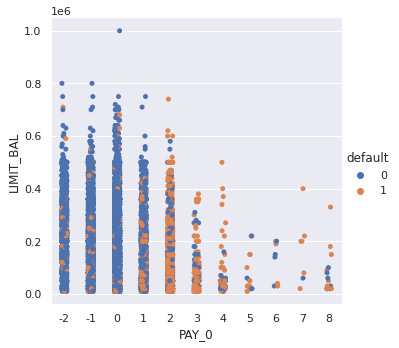

In [96]:
sns.catplot(data=df4,x='PAY_0',y='LIMIT_BAL',hue='default');

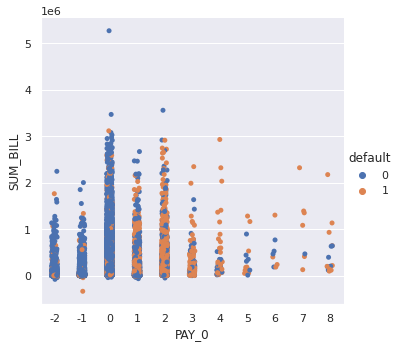

In [97]:
sns.catplot(data=df4,x='PAY_0',y='SUM_BILL',hue='default');

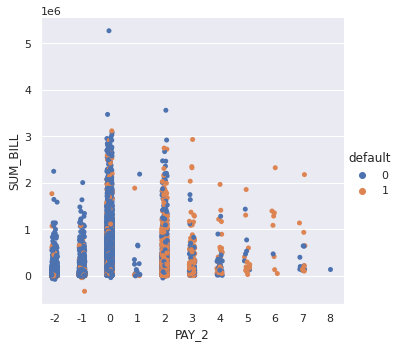

In [98]:
sns.catplot(data=df4,x='PAY_2',y='SUM_BILL',hue='default');

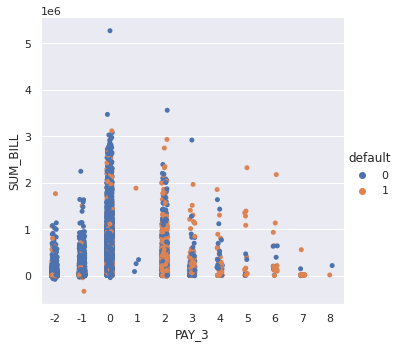

In [99]:
sns.catplot(data=df4,x='PAY_3',y='SUM_BILL',hue='default');

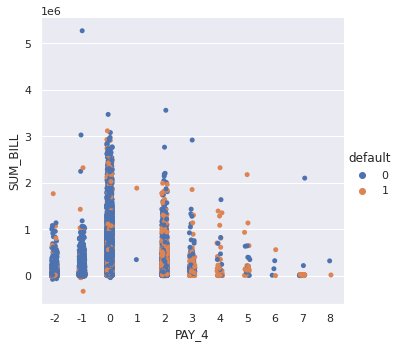

In [100]:
sns.catplot(data=df4,x='PAY_4',y='SUM_BILL',hue='default');

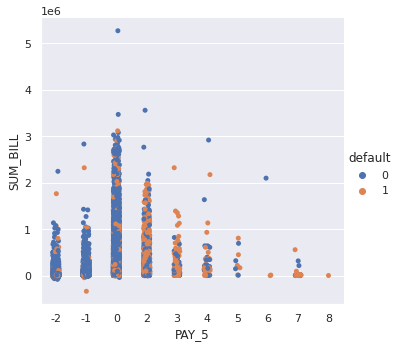

In [101]:
sns.catplot(data=df4,x='PAY_5',y='SUM_BILL',hue='default');

## Análise Bivariada

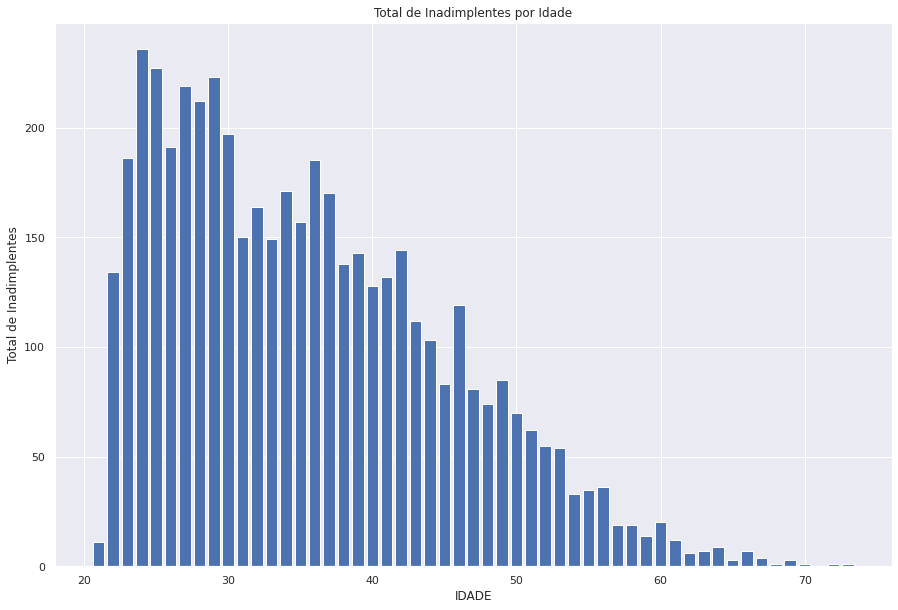

In [102]:
df4_aux = df4[df4['default']==1].copy()
aux = df4_aux[['AGE','default']].groupby('AGE').count().reset_index()
plt.bar(aux['AGE'], aux['default'])
plt.xlabel('IDADE')
plt.ylabel('Total de Inadimplentes')
plt.title('Total de Inadimplentes por Idade')
plt.show()

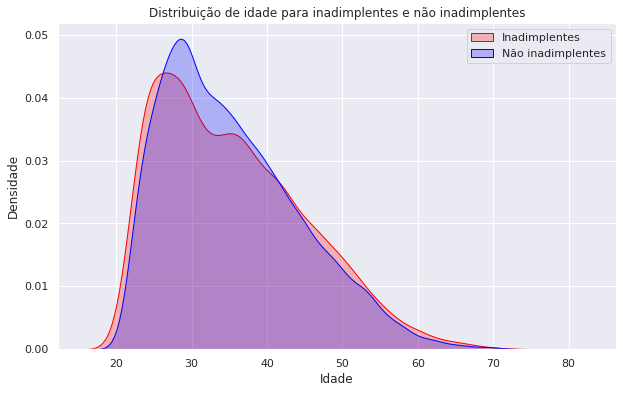

In [103]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['AGE'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['AGE'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Idade')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de idade para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

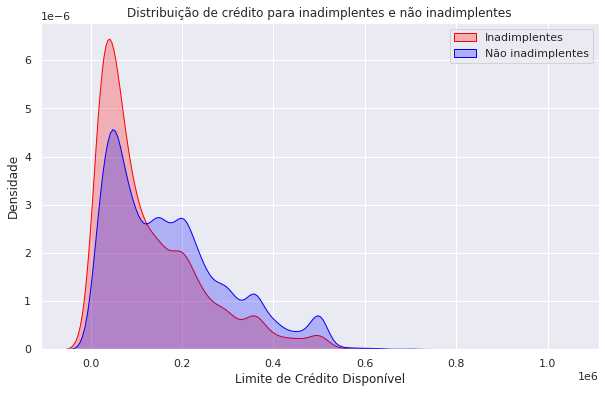

In [104]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['LIMIT_BAL'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['LIMIT_BAL'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Limite de Crédito Disponível')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de crédito para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

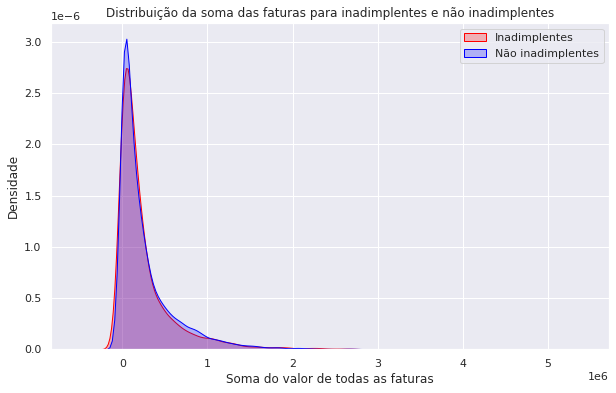

In [105]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['SUM_BILL'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['SUM_BILL'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Soma do valor de todas as faturas')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição da soma das faturas para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

KeyError: 'PAY_AMT1'

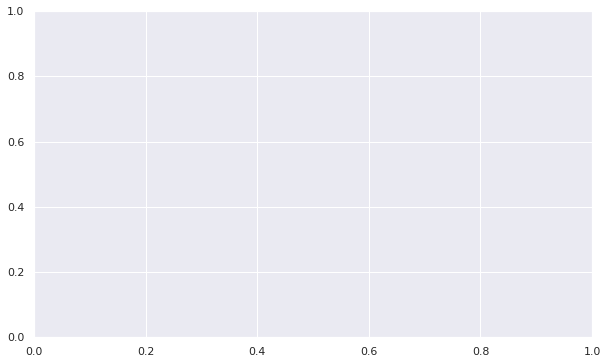

In [106]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['PAY_AMT1'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['PAY_AMT1'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Limite de Crédito Disponível')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de crédito para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

In [134]:
df4.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default',
       'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY'],
      dtype='object')

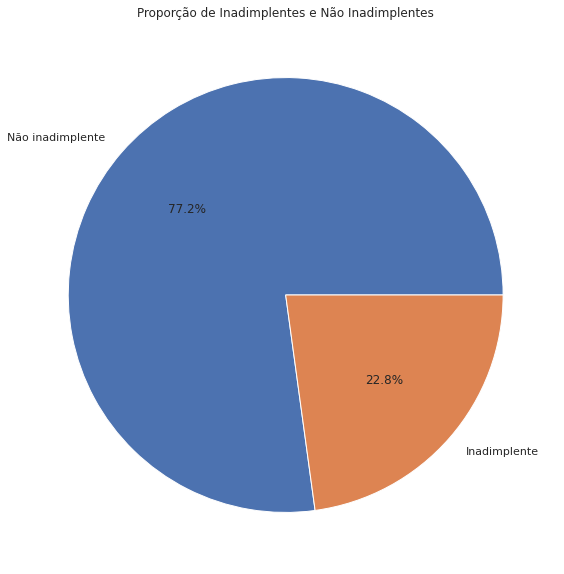

In [135]:
plt.pie(df4['default'].value_counts(), labels=['Não inadimplente', 'Inadimplente'], autopct='%1.1f%%')
plt.title('Proporção de Inadimplentes e Não Inadimplentes')
plt.show()

ValueError: Could not interpret value `PAY_AMT1` for parameter `x`

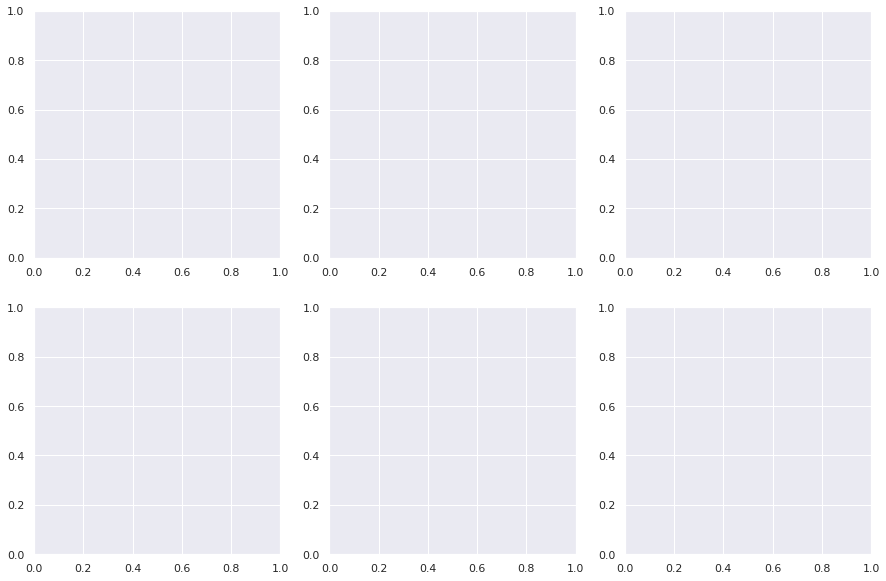

In [136]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.scatterplot(x='PAY_AMT1', y='BILL_AMT1', data=df4, hue='default', ax=axs[0, 0])
sns.scatterplot(x='PAY_AMT2', y='BILL_AMT2', data=df4, hue='default', ax=axs[0, 1])
sns.scatterplot(x='PAY_AMT3', y='BILL_AMT3', data=df4, hue='default', ax=axs[0, 2])
sns.scatterplot(x='PAY_AMT4', y='BILL_AMT4', data=df4, hue='default', ax=axs[1, 0])
sns.scatterplot(x='PAY_AMT5', y='BILL_AMT5', data=df4, hue='default', ax=axs[1, 1])
sns.scatterplot(x='PAY_AMT6', y='BILL_AMT6', data=df4, hue='default', ax=axs[1, 2])

fig.subplots_adjust(wspace=0.4)
plt.suptitle('Relação entre valores pagos e valores das faturas')
plt.show()

## Análise Multivariada

In [ ]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
cat_attributtes = df4.select_dtypes(exclude = ['int64','float64'])

In [ ]:
corr = num_attributes.corr(method='pearson')

In [ ]:
sns.set(rc = {'figure.figsize':(30,20)})
sns.heatmap(corr,annot=True);

In [137]:
cor_dict = dict(corr['default'])
cor_dict

{'ID': 0.009604055460692726,
 'SAFRA': 0.008226731741860024,
 'LIMIT_BAL': -0.14762038395399393,
 'AGE': 0.006701528478051911,
 'PAY_0': 0.3229564633657247,
 'PAY_2': 0.26016610314539823,
 'PAY_3': 0.23200875685031191,
 'PAY_4': 0.21263623638958556,
 'PAY_5': 0.2076795114475631,
 'PAY_6': 0.1868026192613604,
 'BILL_AMT1': -0.026488445701884078,
 'default': 1.0,
 'SUM_BILL': -0.016729042818866686,
 'AVG_BILL': -0.016729042818866648,
 'max_BILL': -0.046814100631402955,
 'SUM_PAY': -0.10965885226183143,
 'AVG_PAY': -0.10965885226183161,
 'max_PAY': -0.08413782602243765}

In [138]:
select_person = []
for chave, valor in cor_dict.items():
    if (valor < -0.1 or valor > 0.1) and chave != 'default':
        select_person.append(chave)
select_person

['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'SUM_PAY',
 'AVG_PAY']

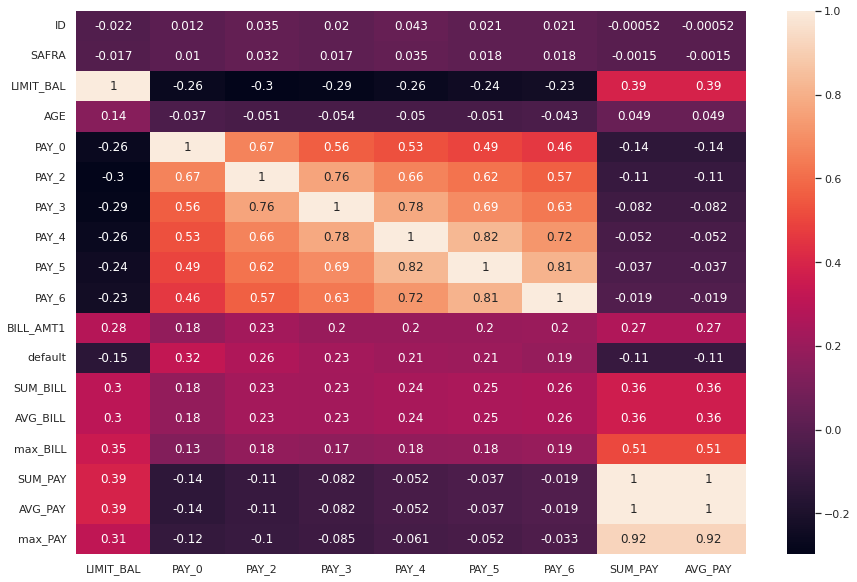

In [139]:
sns.heatmap(corr[select_person],annot=True);

<Axes: >

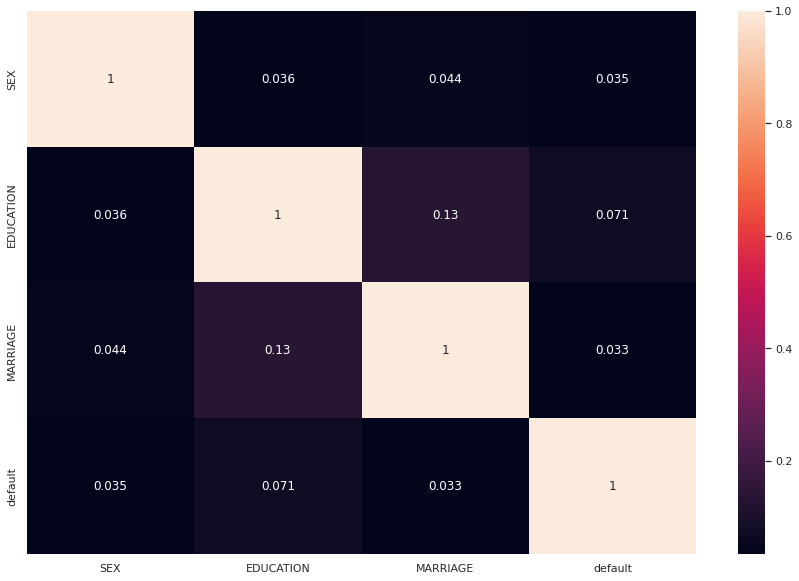

In [140]:
sns.set(rc = {'figure.figsize':(15,10)})
# only categorical data
a = df4[['SEX','EDUCATION','MARRIAGE','default']]

# Calculate cramer V
a1 = cramer_v( a['SEX'], a['SEX'] )
a2 = cramer_v( a['SEX'], a['EDUCATION'] )
a3 = cramer_v( a['SEX'], a['MARRIAGE'] )
a4 = cramer_v( a['SEX'], a['default'] )


a5 = cramer_v( a['EDUCATION'], a['SEX'] )
a6 = cramer_v( a['EDUCATION'], a['EDUCATION'] )
a7 = cramer_v( a['EDUCATION'], a['MARRIAGE'] )
a8 = cramer_v( a['EDUCATION'], a['default'] )


a9 = cramer_v( a['MARRIAGE'], a['SEX'] )
a10 = cramer_v( a['MARRIAGE'], a['EDUCATION'] )
a11 = cramer_v( a['MARRIAGE'], a['MARRIAGE'] )
a12 = cramer_v( a['MARRIAGE'], a['default'] )

a13 = cramer_v( a['default'], a['SEX'] )
a14 = cramer_v( a['default'], a['EDUCATION'] )
a15 = cramer_v( a['default'], a['MARRIAGE'] )
a16 = cramer_v( a['default'], a['default'] )


# Final dataset
d = pd.DataFrame( {'SEX': [a1, a2, a3,a4], 'EDUCATION': [a5, a6, a7,a8], 'MARRIAGE': [a9, a10, a11,a12] , 'default' : [a13,a14,a15,a16] })

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# PASSO 5 - Data Preparation (Unbalanced DataSet)

In [115]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [116]:
df5.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default',
       'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY'],
      dtype='object')

In [117]:
cols_rescaling= ['LIMIT_BAL','SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY']

rs = RobustScaler()
df5[cols_rescaling] = rs.fit_transform(df5[cols_rescaling].values)

df_OOT[cols_rescaling] = rs.transform(df_OOT[cols_rescaling].values)

In [118]:
num_attributes = df5.select_dtypes(include=['int64' , 'float64'])

#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,1.000000,21000.000000,20999.000000,10500.500000,1.050050e+04,6062.177820,0.000000,-1.200000
1,SAFRA,200510.000000,200604.000000,94.000000,200563.285714,2.006010e+05,45.291798,-0.288063,-1.915213
2,LIMIT_BAL,-0.666667,4.833333,5.500000,0.184869,0.000000e+00,0.714876,1.028252,0.602996
3,AGE,21.000000,79.000000,58.000000,35.415286,3.400000e+01,9.246949,0.734517,0.045975
4,PAY_0,-2.000000,8.000000,10.000000,0.018476,0.000000e+00,1.123405,0.807518,3.099244
5,PAY_2,-2.000000,8.000000,10.000000,-0.103238,0.000000e+00,1.203886,0.820207,1.673044
6,PAY_3,-2.000000,8.000000,10.000000,-0.136238,0.000000e+00,1.209314,0.917693,2.444372
7,PAY_4,-2.000000,8.000000,10.000000,-0.196381,0.000000e+00,1.169821,1.070557,3.897242
8,PAY_5,-2.000000,8.000000,10.000000,-0.234857,0.000000e+00,1.144504,1.061523,4.143238
9,PAY_6,-2.000000,8.000000,10.000000,-0.261762,0.000000e+00,1.167988,1.002820,3.507251


## 5.1 Transformation

### 5.1.1 Encoding

In [119]:
df5['SEX'].unique()

array(['female', 'male'], dtype=object)

In [120]:
df5['MARRIAGE'].unique()

array(['married', 'single', 'others'], dtype=object)

In [121]:
#Ordinal Encoding
df5['SEX'] = df5['SEX'].apply(lambda x: 1 if x=='male' else 2)
df_OOT['SEX'] = df_OOT['SEX'].apply(lambda x: 1 if x=='male' else 2)

df5['MARRIAGE'] = df5['MARRIAGE'].apply(lambda x: 1 if x=='married' else 2 if x=='single' else 3)
df_OOT['MARRIAGE'] = df_OOT['MARRIAGE'].apply(lambda x: 1 if x=='married' else 2 if x=='single' else 3)

df5['EDUCATION'] = df5['EDUCATION'].apply(lambda x: 1 if x=='others' else 2 if x=='high school' else 3 if x=='graduate school'
                                         else 4)
df_OOT['EDUCATION'] = df_OOT['EDUCATION'].apply(lambda x: 1 if x=='others' else 2 if x=='high school' else 3 if x=='graduate school'
                                         else 4)

### 5.1.1 Nature Transformation

# PASSO 5 - Data Preparation (Balanced DataSet)

In [122]:
df_balanced = df4.copy()

In [123]:
df_balanced.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default',
       'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY'],
      dtype='object')

## Enconding

In [124]:
#oe = OrdinalEncoder()

df_balanced['SEX'] = df_balanced['SEX'].apply(lambda x: 1 if x=='male' else 2)

df_balanced['MARRIAGE'] = df_balanced['MARRIAGE'].apply(lambda x: 1 if x=='married' else 2 if x=='single' else 3)

#Ordinal Encoding
df_balanced['EDUCATION'] = df_balanced['EDUCATION'].apply(lambda x: 1 if x=='others' else 2 if x=='high school' else 3 if x=='graduate school'
                                         else 4)

In [125]:
#Balancinng using OverSampling(SMOTE e ADASYN)
from imblearn.over_sampling import SMOTE, ADASYN
smo = SMOTE()
ada = ADASYN()

X_train = df_balanced.drop(['ID', 'SAFRA','default'],axis=1)
y_train = df_balanced['default']

X_smo, y_smo = smo.fit_resample(X_train, y_train)
X_ada, y_ada = ada.fit_resample(X_train, y_train)

## Rescaling

In [126]:
rs = RobustScaler()


X_smo[cols_rescaling] = rs.fit_transform(X_smo[cols_rescaling].values)
X_ada[cols_rescaling] = rs.fit_transform(X_ada[cols_rescaling].values)

pickle.dump(rs,open('parameter/cols_scaler.pkl','wb'))

In [218]:
X_smo = X_smo.drop(['LIMIT_BAL', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SUM_BILL', 'AVG_BILL', 'max_BILL',
       'SUM_PAY', 'AVG_PAY', 'max_PAY'],axis=1).copy()
X_ada = X_ada.drop(['LIMIT_BAL', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SUM_BILL', 'AVG_BILL', 'max_BILL',
       'SUM_PAY', 'AVG_PAY', 'max_PAY'],axis=1).copy()

# PASSO 6 - Feature Selection 

In [157]:
#df6 é o dataset desbalanceado
df6 = df5.copy()

In [158]:
df6.dtypes

ID             int64
SAFRA          int64
LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
default        int64
SUM_BILL     float64
AVG_BILL     float64
max_BILL     float64
SUM_PAY      float64
AVG_PAY      float64
max_PAY      float64
dtype: object

In [159]:
X = df6.drop(['default','ID','SAFRA'], axis=1)
y = df6['default']

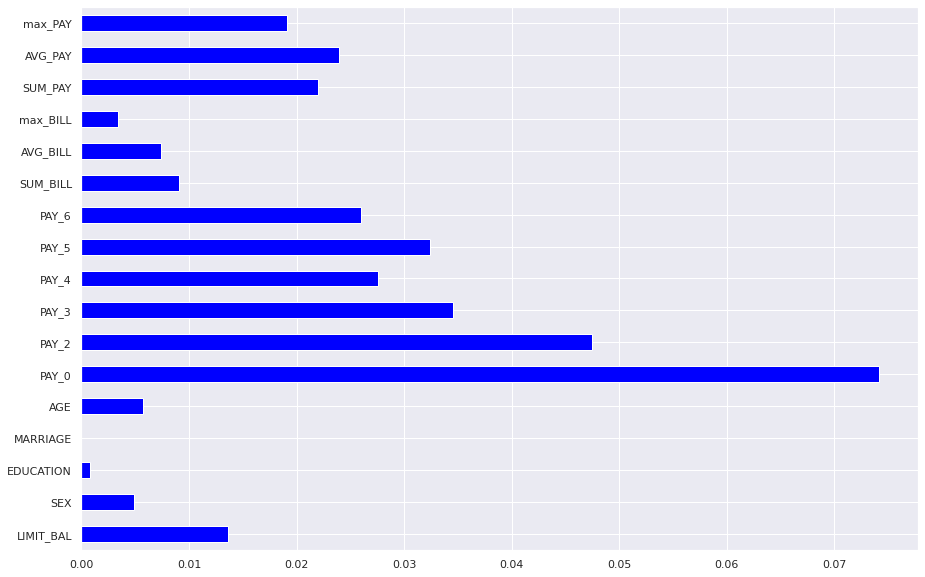

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Assuming that X and y have already been defined
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importances = feat_importances.iloc[:28]
feat_importances.plot(kind='barh', color='blue')
plt.show()

In [161]:
rf = RandomForestClassifier( n_jobs=-1 )
# define boruta
boruta =BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X.values, y.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	15
I

In [162]:
cols_selected = boruta.support_.tolist()
# best features
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['PAY_0', 'SUM_PAY']

In [163]:
df6.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default',
       'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY'],
      dtype='object')

In [164]:
cols_selected_final = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY', 'max_PAY','default']

In [199]:
df6 = df6[cols_selected_final].copy()
df_OOT = df_OOT[cols_selected_final].copy()

# PASSO 6 - Feature Selection (Balanaced Dataset)

In [145]:
X = df_balanced.drop(['default','ID','SAFRA'], axis=1)
y = df_balanced['default']

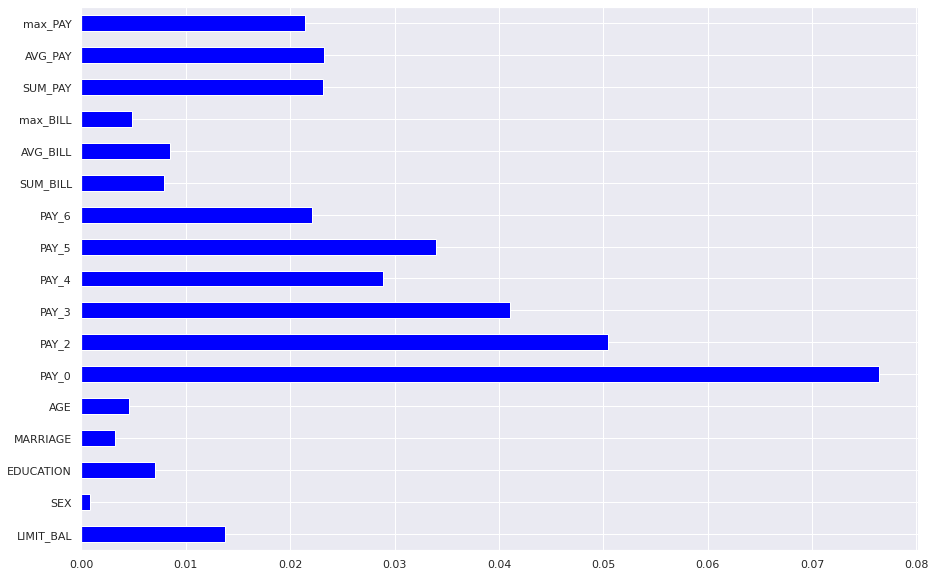

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Assuming that X and y have already been defined
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importances = feat_importances.iloc[:28]
feat_importances.plot(kind='barh', color='blue')
plt.show()

In [147]:
rf = RandomForestClassifier( n_jobs=-1 )
# define boruta
boruta =BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X.values, y.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	14
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	15
I

In [148]:
cols_selected = boruta.support_.tolist()
# best features
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['PAY_0', 'SUM_PAY']

In [205]:
cols_selected_final

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'SUM_BILL',
 'AVG_BILL',
 'max_BILL',
 'SUM_PAY',
 'AVG_PAY',
 'max_PAY',
 'default']

In [208]:
cols_selected_balanced = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SUM_BILL', 'AVG_BILL','max_BILL','SUM_PAY','AVG_PAY','max_PAY']

# PASSO 7 - Machine Learning Modelling 

In [170]:
#Models which be used 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb


models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Gradient Boosting' : GradientBoostingClassifier(),
          'AdaBoostClassifier' : AdaBoostClassifier(),
          'GaussianNB' : GaussianNB(),
          'Extra Trees' : ExtraTreesClassifier(),
          'XGBoosting' : xgb.XGBClassifier()
         }

In [196]:
#function for calculate metrics for each models
from sklearn.metrics import make_scorer, average_precision_score

auprc_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

def model_tester(X,y,models):
    results = []
    for model_name, model in models.items():
        num_folds = 10
        seed = 7
        
        kfold = KFold(num_folds, shuffle=True,random_state=seed)
        scores = cross_val_score(model, X, y , cv=kfold, scoring=auprc_scorer )
        results.append({'Model': model_name , 'AP': np.mean(scores)})

    return pd.DataFrame( results )

In [202]:
#fuction for plot the auprc curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_aurpc(X,y,models):

    results = []

    # Plot das curvas de Precision-Recall
    for model_name, model in models.items():
        m = model.fit(X,y)
        y_pred = m.predict_proba(df_OOT.drop(['default'],axis=1))[:,1]
        precision, recall, threshold = precision_recall_curve(df_OOT['default'], y_pred)
        plt.plot(recall, precision, label=model_name)
        ap = average_precision_score(df_OOT['default'], y_pred)
        results.append({'Model': model_name , 'AP': ap})

    df_aurpc= pd.DataFrame(results)
    
    # Configurações do plot
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de Precision-Recall')
    plt.legend(loc='best')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

## 7.1 Machine Learning Modelling With Unbalanced Dataset

In [182]:
df7 = df6.copy()

In [183]:
X = df7.drop(['default'] , axis=1) 
y = df7['default']

In [184]:
#sem balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score , cross_validate
from sklearn.metrics import average_precision_score

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
result_tree=cross_val_score(model_tree,X,y,cv=kfold,scoring='accuracy')
print("Accuracy Value: {:.4f}" .format(result_tree.mean()))

Accuracy Value: 0.7225


In [200]:
model_tester(X,y,models)

,Model,AP
0,Logistic Regression,0.508131
1,KNN,0.414737
2,Decision Tree,0.301379
3,Random Forest,0.522481
4,Gradient Boosting,0.554693
5,AdaBoostClassifier,0.539974
6,GaussianNB,0.496126
7,Extra Trees,0.509813
8,XGBoosting,0.530535


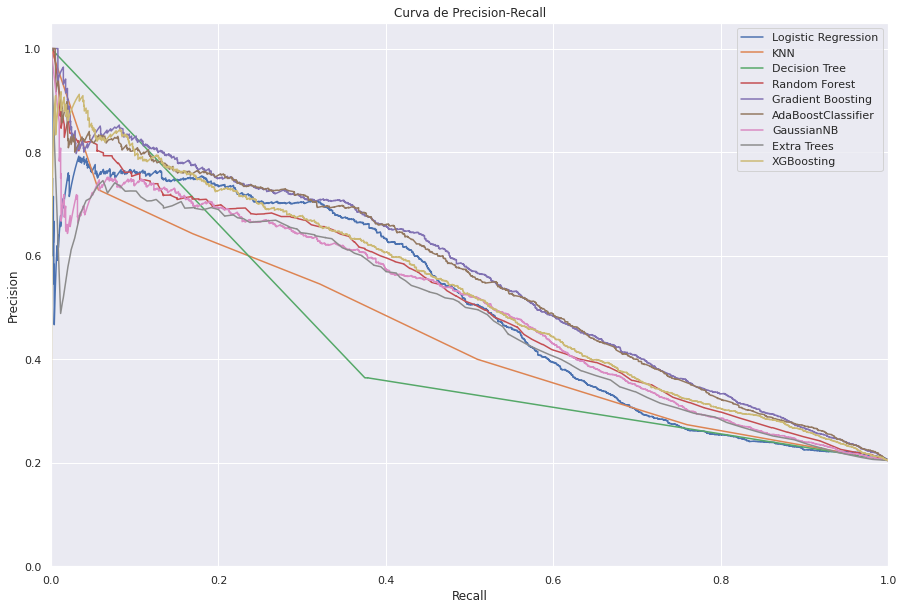

In [203]:
plot_aurpc(X,y,models)

## 7.2 Machine Learning Modeling - Balanced With SMOTE

In [219]:
#Com balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score , cross_validate
from sklearn.metrics import average_precision_score

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
result_tree=cross_val_score(model_tree,X_smo,y_smo,cv=kfold,scoring='accuracy')
result_rf = cross_val_score(model_rf,X_smo,y_smo,cv=kfold,scoring='accuracy')
print("Accuracy Value (Decision Tree): {:.4f}" .format(result_tree.mean()))
print("Accuracy Value (Random Forest): {:.4f}" .format(result_rf.mean()))

Accuracy Value (Decision Tree): 0.6397
Accuracy Value (Random Forest): 0.6394


In [220]:
model_tester(X_smo,y_smo,models)

,Model,AP
0,Logistic Regression,0.689496
1,KNN,0.528974
2,Decision Tree,0.686504
3,Random Forest,0.695350
4,Gradient Boosting,0.707026
5,AdaBoostClassifier,0.700500
6,GaussianNB,0.673138
7,Extra Trees,0.688672
8,XGBoosting,0.703040


In [221]:
plot_aurpc(X_smo,y_smo,models)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AVG_BILL
- AVG_PAY
- LIMIT_BAL
- PAY_0
- PAY_2
- ...
Feature names seen at fit time, yet now missing:
- EDUCATION
- MARRIAGE
- SEX


## 7.3 Machine Learning Modelling - Balanced DataSet with ADASYN

In [ ]:
#Com balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score , cross_validate
from sklearn.metrics import average_precision_score

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
result_tree=cross_val_score(model_tree,X_ada,y_ada,cv=kfold,scoring='accuracy')
result_rf = cross_val_score(model_rf,X_ada,y_ada,cv=kfold,scoring='accuracy')
print("Accuracy Value (Decision Tree): {:.4f}" .format(result_tree.mean()))
print("Accuracy Value (Random Forest): {:.4f}" .format(result_rf.mean()))

In [ ]:
model_tester(X_ada,y_ada,models)

In [ ]:
plot_aurpc(X_ada,y_ada,models)

# PASSO 8 - Hyperparameter Fine Tuning

In [142]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# Define the hyperparameter search space
param_space = {
    "learning_rate": Real(0.01, 1.0, prior="log-uniform"),
    "max_depth": Integer(1, 10),
    "n_estimators": Integer(50, 500),
    "min_child_weight": Integer(1, 10),
    "subsample": Real(0.5, 1.0, prior="uniform"),
    "colsample_bytree": Real(0.5, 1.0, prior="uniform"),
    "gamma": Real(1e-6, 1.0, prior="log-uniform"),
    "reg_alpha": Real(1e-9, 1.0, prior="log-uniform"),
    "reg_lambda": Real(1e-9, 1.0, prior="log-uniform"),
    "scale_pos_weight": Real(1e-6, 500, prior="log-uniform"),
    "objective": Categorical(["binary:logistic"]),
}

# Define the XGBoost classifier
clf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
)

# Define the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=clf,
    search_spaces=param_space,
    scoring="average_precision",
    cv=5,
    n_jobs=-1,
    n_iter=20,
    verbose=0,
    random_state=42,
)

# Fit the BayesSearchCV object to the data
bayes_cv.fit(X_smo, y_smo)

# Print the best hyperparameters and best average precision score
print("Best hyperparameters: ", bayes_cv.best_params_)
print("Best AUPRC: {:.4f}".format(bayes_cv.best_score_))

Best hyperparameters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 1e-06), ('learning_rate', 0.05311078800069953), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 325), ('objective', 'binary:logistic'), ('reg_alpha', 4.065131679512596e-08), ('reg_lambda', 1.0), ('scale_pos_weight', 40.33716590681101), ('subsample', 0.5738804041433168)])
Best AUPRC: 0.9028


# PASSO 9 -  Utilizando DataSet de Teste para Calibrar PD e Calcular PD, LGD e EAD. 

In [211]:
test_df = df_OOT.drop(['ID','SAFRA','default'],axis=1)

In [143]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier().fit(X_smo,y_smo)


In [238]:
#Salvando modelo
pickle.dump( xgb_model,open('model/creditscore.pkl','wb'))

In [212]:
test_df['y_score'] = xgb_model.predict_proba(test_df)[:,1]

In [213]:
test_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SUM_BILL,AVG_BILL,max_BILL,SUM_PAY,AVG_PAY,max_PAY,y_score
21000,-0.555556,1,4,1,36,1,-1,-1,-1,0,...,-0.398109,-0.396799,-0.355943,-0.407430,-0.407430,-0.438912,-0.452968,-0.452968,1170,0.849476
21001,0.833333,1,2,1,40,2,0,0,0,0,...,1.396777,1.448052,1.549774,3.277224,3.277224,2.356650,1.332486,1.332486,10000,0.955861
21002,0.722222,1,4,1,37,0,0,0,0,0,...,0.137587,0.681965,0.777959,0.639827,0.639827,1.427677,0.430247,0.430247,6015,0.420608
21003,0.388889,1,4,2,32,2,0,0,0,-2,...,-0.398109,-0.396799,-0.355943,0.913839,0.913839,1.927765,-0.081336,-0.081336,7600,0.913065
21004,-0.277778,1,4,2,32,2,0,0,0,0,...,2.265717,-0.396799,0.897818,0.985423,0.985423,0.704592,0.415651,0.415651,10000,0.818092


In [218]:
test_df = pd.concat([test_df,df_OOT['default']],axis=1)
test_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT5,PAY_AMT6,SUM_BILL,AVG_BILL,max_BILL,SUM_PAY,AVG_PAY,max_PAY,y_score,default
21000,-0.555556,1,4,1,36,1,-1,-1,-1,0,...,-0.396799,-0.355943,-0.407430,-0.407430,-0.438912,-0.452968,-0.452968,1170,0.849476,0
21001,0.833333,1,2,1,40,2,0,0,0,0,...,1.448052,1.549774,3.277224,3.277224,2.356650,1.332486,1.332486,10000,0.955861,1
21002,0.722222,1,4,1,37,0,0,0,0,0,...,0.681965,0.777959,0.639827,0.639827,1.427677,0.430247,0.430247,6015,0.420608,0
21003,0.388889,1,4,2,32,2,0,0,0,-2,...,-0.396799,-0.355943,0.913839,0.913839,1.927765,-0.081336,-0.081336,7600,0.913065,1
21004,-0.277778,1,4,2,32,2,0,0,0,0,...,-0.396799,0.897818,0.985423,0.985423,0.704592,0.415651,0.415651,10000,0.818092,1


In [219]:

# Exposure at default ratio, percentual do montante total devido em relação ao principal
test_df['ead'] = test_df['SUM_BILL'] - test_df['SUM_PAY']
test_df['ead_ratio'] = test_df['ead']/test_df['SUM_BILL']

# Loss given default ratio, percentual de recuperação em relação total devido
test_df['lgd_ratio'] = 1 - test_df['SUM_PAY']/test_df['ead']

#perdas
test_df['losses'] = test_df['SUM_BILL'] - test_df['SUM_PAY']

test_df[test_df.default == 1][['SUM_BILL','SUM_PAY','ead','ead_ratio','lgd_ratio','losses']]

,SUM_BILL,SUM_PAY,ead,ead_ratio,lgd_ratio,losses
21001,3.277224,1.332486,1.944738,0.593410,0.314825,1.944738
21003,0.913839,-0.081336,0.995175,1.089004,1.081730,0.995175
21004,0.985423,0.415651,0.569772,0.578200,0.270496,0.569772
21007,2.687547,11.536903,-8.849356,-3.292726,2.303700,-8.849356
21012,-0.367102,-0.528065,0.160963,-0.438468,4.280670,0.160963
...,...,...,...,...,...,...
29991,-0.367102,-0.528065,0.160963,-0.438468,4.280670,0.160963
29994,1.131397,0.299925,0.831472,0.734907,0.639284,0.831472
29997,-0.184706,0.677334,-0.862040,4.667101,1.785734,-0.862040
29998,0.459859,5.140046,-4.680187,-10.177446,2.098256,-4.680187


In [220]:
test_df[test_df.default == 0][['SUM_BILL','SUM_PAY','ead','ead_ratio','lgd_ratio','losses']]

,SUM_BILL,SUM_PAY,ead,ead_ratio,lgd_ratio,losses
21000,-0.407430,-0.452968,0.045538,-0.111770,10.946949,0.045538
21002,0.639827,0.430247,0.209580,0.327557,-1.052899,0.209580
21005,-0.176315,0.027227,-0.203542,1.154425,1.133768,-0.203542
21006,-0.351727,-0.474149,0.122422,-0.348059,4.873075,0.122422
21008,-0.195982,3.311343,-3.507326,17.896143,1.944122,-3.507326
...,...,...,...,...,...,...
29990,1.715444,0.347409,1.368035,0.797481,0.746052,1.368035
29992,-0.353292,-0.451043,0.097751,-0.276686,5.614209,0.097751
29993,0.578037,4.277511,-3.699474,-6.400061,2.156249,-3.699474
29995,1.967577,1.110585,0.856992,0.435557,-0.295910,0.856992


## Criando Categorias de Risco

In [221]:
test_df['risk_category'], bins = pd.qcut(test_df.y_score, 8 , labels=['A','B','C','D','E','F','G','H'], retbins=True)
test_df['risk_category']

21000    H
21001    H
21002    D
21003    H
21004    G
        ..
29995    D
29996    F
29997    E
29998    A
29999    G
Name: risk_category, Length: 9000, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'H']

In [229]:
test_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,SUM_PAY,AVG_PAY,max_PAY,y_score,default,ead,ead_ratio,lgd_ratio,losses,risk_category
21000,-0.555556,1,4,1,36,1,-1,-1,-1,0,...,-0.452968,-0.452968,1170,0.849476,0,0.045538,-0.111770,10.946949,0.045538,H
21001,0.833333,1,2,1,40,2,0,0,0,0,...,1.332486,1.332486,10000,0.955861,1,1.944738,0.593410,0.314825,1.944738,H
21002,0.722222,1,4,1,37,0,0,0,0,0,...,0.430247,0.430247,6015,0.420608,0,0.209580,0.327557,-1.052899,0.209580,D
21003,0.388889,1,4,2,32,2,0,0,0,-2,...,-0.081336,-0.081336,7600,0.913065,1,0.995175,1.089004,1.081730,0.995175,H
21004,-0.277778,1,4,2,32,2,0,0,0,0,...,0.415651,0.415651,10000,0.818092,1,0.569772,0.578200,0.270496,0.569772,G


In [230]:
default_table = test_df.groupby(['risk_category']).agg(
    default_ratio=('default','mean'),
    sum_bill=('SUM_BILL','mean'),
).reset_index()


In [232]:
policy_table = test_df[test_df.default == 1].groupby(['risk_category']).agg(
    EAD=('ead_ratio', 'mean'),
    LGD=('lgd_ratio', 'mean'),
).reset_index()

policy_table = pd.merge(policy_table, default_table, on=['risk_category'])

In [233]:
policy_table

,risk_category,EAD,LGD,default_ratio,sum_bill
0,A,-4.718192,2.333183,0.070222,0.701602
1,B,-1.824629,1.821036,0.087111,0.640249
2,C,1.080538,-5.894509,0.128000,0.671528
3,D,-15.010645,2.272580,0.153778,0.505359
4,E,3.314343,-0.678609,0.144000,0.424626
5,F,-0.723982,1.037734,0.205333,0.359474
6,G,-0.227815,-6.719074,0.301333,0.364924
7,H,-2.345233,2.263130,0.545778,0.454329


## Criando Política de Crédito

In [234]:
# term will have an effect on the probability of default, also on the EAD/LGD
def compute_roi(loan_amnt, default_prob, EAD, LGD, loan_fees, term_years):
    EAD_LGD = EAD*LGD
    principal = loan_amnt
    expected_loss = principal*EAD_LGD*default_prob
    profit = loan_amnt
    net_profit = profit - expected_loss - loan_fees*loan_amnt
    ROI = net_profit/loan_amnt
    ROI_annualized = ROI/term_years

    return {
        'ROI': ROI,
        'ROI_annualized': ROI_annualized,
        'principal': principal,
        'expected_loss': expected_loss,
        'profit': profit,
        'net_profit': net_profit,
        'default_prob': default_prob,
        'EAD': EAD,
        'LGD': LGD
    }

compute_roi(loan_amnt=50000, default_prob=0.14, EAD=0.2, LGD=0.87, loan_fees=0.002, term_years=3)

{'ROI': 0.97364,
 'ROI_annualized': 0.32454666666666665,
 'principal': 50000,
 'expected_loss': 1218.0000000000002,
 'profit': 50000,
 'net_profit': 48682.0,
 'default_prob': 0.14,
 'EAD': 0.2,
 'LGD': 0.87}

In [236]:
def compute_best_interest_rate(term_years, expected_losses, loan_fees, ir_constraint=0.025):
    best_ir = (0.025*term_years + expected_losses + loan_fees)/(1 - expected_losses)
    return best_ir

def compute_policy_interest_rate(loan_amnt, loan_fees, risk, policy_table):
    term_months = policy_3.term.iloc[0]
    term_years = term_months/12

    default_prob = policy_table.loc[policy_table.risk_category == risk, 'default_ratio'].item()
    EAD = policy_table.loc[policy_table.risk_category == risk, 'EAD'].item()
    LGD = policy_table.loc[policy_table.risk_category == risk, 'LGD'].item()

    expected_losses = EAD*LGD*default_prob
    best_ir = compute_best_interest_rate(term_years, expected_losses, loan_fees)

    roi_return = compute_roi(best_ir, loan_amnt, default_prob, EAD, LGD, loan_fees, term_years)

    policy_ret = {'best_interest_rate': best_ir}
    policy_ret.update(roi_return)

    return policy_ret

compute_policy_interest_rate(50000, 0.002, 'B',  policy_table)

NameError: name 'policy_3' is not defined

# PASSO 10 - Tradução e Interpretação do Erro

# PASSO 11 - Deploy Model To Production

## 10.1 Credit Class

In [105]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class CreditCard( object ):
    
    def __init__(self):
        self.home_path = 
        self.gender_scaler = 
        self.cols_scaler = 
        
    def data_cleaning(self,df_raw):
        
        df_raw['SEX'] = df_raw['SEX'].apply(lambda x: 'male' if x==1 else 'female')
        df_raw['EDUCATION'] = df_raw['EDUCATION'].apply(lambda x: 'graduate school' if x == 1 else 'university' if x==2 else
                                               'high school' if x==3 else 'others')
        df_raw['MARRIAGE'] = df_raw['MARRIAGE'].apply(lambda x: 'married' if x==1 else 'single' if x==2 else 'others')
        
        
        return df_raw
    
    def feature_engineering(self,df2):
        
        df2['SUM_BILL'] = df2['BILL_AMT1'] + df2['BILL_AMT2'] + df2['BILL_AMT3'] + df2['BILL_AMT4'] + df2['BILL_AMT5'] + df2['BILL_AMT6']   
        df2['AVG_BILL'] = df2['SUM_BILL'] / 6
        df2['max_BILL'] = df2[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

        df2['SUM_PAY'] = df2['PAY_AMT1'] + df2['PAY_AMT2'] + df2['PAY_AMT3'] + df2['PAY_AMT4'] + df2['PAY_AMT5'] + df2['PAY_AMT6']
        df2['AVG_PAY'] = df2['SUM_PAY'] / 6
        df2['max_PAY'] = df2[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']].max(axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        
        return df5[cols_select]
    
    def get_prediction(self, model, original_data, test_data):
        
        return original_data.to_json()

SyntaxError: invalid syntax (4000454909.py, line 11)

## 10.2 API Handler

## 10.3 API Tester

In [ ]:
data = {"model": model_tree }
with open('saved_steps2.pkl' , 'wb') as file:
    pickle.dump(data,file)

In [ ]:
with open('saved_steps2.pkl' , 'rb') as file:
    data =  pickle.load(file)

In [ ]:
classificator = data['model']

In [ ]:
classificator.predict(X)[0]

In [ ]:
cols_selected